In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *


from RiverSwim import *
from CurriculumQ import CurriculumQ

In [ ]:
#River Swim Environment
nS = 150
uniform_restart = False
num_runs = 10


small = 5e-3
large = 1.
nA = 2
gamma = 0.999

original_mu = np.zeros(nS)
original_mu[1] = 1
if uniform_restart:
    mu = np.ones(nS) / nS
else:
    mu = original_mu

xi = np.ones(nS) * 1/nS

episodes = 15000000
checkpoint_step=500
test_episodes = 10000
discount_tau = True
param_decay=True
debug = False

lam = 1
experiment_results = []
tests_returns = []
tests_lens = []
exp_taus = []

In [ ]:
model_lr = 0.11869281717397965
tau = 0.
batch_size = 30
exp_rate = 0.4
eps_model = compute_eps_model(gamma, tau, episodes/10)

In [ ]:

run_name = f"Q_{uniform_restart}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"RiverSwim_{nS}_{uniform_restart}"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

save_path = f"results/{experiment_name}/run_{run_name}"
label = run_name.split("_")[0]

In [ ]:
def run_experiment(index, seed, run_name):
    sub_run_name = f"{run_name}_{index}"
    
    with mlflow.start_run(nested=True, run_name=sub_run_name):
        
        # Environment specific configuration   
        set_policy_seed(seed)
        env = RiverSwim(nS, mu, small=small, large=large, seed=seed)
        
        # Environment independent configuration
        tmdp = TMDP(env, xi, tau=tau, 
                    gamma=gamma, discount_tau=discount_tau, 
                    seed=seed)
        tmdp.update_tau(tau)
        curr_Q = CurriculumQ(tmdp, checkpoint_step=checkpoint_step)

        curr_Q.train(model_lr, batch_size=batch_size, 
                lam=lam, exp_rate=exp_rate,
                episodes=episodes,
                eps_model=eps_model,
                param_decay=param_decay,
                debug=debug,)
    
        avg_return = np.average(curr_Q.reward_records[-10:])/batch_size
        
        mlflow.log_metric("Avg Return", avg_return)
        
        test_policies = test_Q_policies_len(tmdp, curr_Q.Qs, test_episodes, mu=original_mu)
        test_policies_return = test_policies[0]
        test_pol_len = test_policies[1]
        
        result_dict = {
            "Qs" : curr_Q.Qs,
            "taus" : curr_Q.taus,
            "reward_records" : curr_Q.reward_records,
            "test_policies_return" : test_policies_return,
            "index" : index,
            "test_pol_len" : test_pol_len,
        }

        tests_returns.append(test_policies_return)
        experiment_results.append(result_dict)
        tests_lens.append(test_pol_len)
        exp_taus.append(curr_Q.taus)

In [ ]:
def run_experiments(num_runs=10):
    with mlflow.start_run(run_name=run_name):
        
        for i in range(num_runs):
            seed = constants.SEEDS[i]
            run_experiment(i, seed, run_name)
        
        pad_results = pad_to_same_length(tests_returns)
        pad_lens = pad_to_same_length(tests_lens)
        pad_taus = pad_to_same_length(exp_taus)
        experiment_dict = {
            "tests_returns": pad_results,
            "taus": pad_taus,
            "tests_lens": pad_lens,
            "num_runs": num_runs,
            "label": label,
            "checkpoint_step": checkpoint_step,
            "uniform_restart": uniform_restart,
        }
        

        mlflow.set_tags(tags={
            "seed": seed,
            "tau": tau,
            "gamma": gamma,
            "checkpoint_step": checkpoint_step,
            "test_episodes": test_episodes,
            "episodes": episodes,
            "model_lr": model_lr,
            "batch_size": batch_size,
            "lam": lam,
            "eps_model": eps_model,
            "exp_rate": exp_rate,
            "param_decay": param_decay,
            "discount_tau": discount_tau,
            "small": small,
            "large": large,
            "uniform_restart": uniform_restart,
        })

        try:
            save_to_mlflow(experiment_dict)
        except Exception as e:
            print(e)
            print("Something went wrong saving the experiment results to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            save(save_path, experiment_dict)

        rewards_fig = plot_avg_test_return(tests_returns, f"{run_name[:-3]} Avg Return on {num_runs} runs")
        try:
            mlflow.log_figure(figure=rewards_fig, artifact_file="reward_image.png")
        except Exception as e:
            print(e)
            print("Something went wrong saving the figure to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            rewards_fig.savefig(save_path+"/reward_image.png")

Episode: 375000 reward: 0.15000000000000005 tau 0.0
Episode: 380000 reward: 0.15000000000000005 tau 0.0
Episode: 385000 reward: 0.15000000000000005 tau 0.0
Episode: 390000 reward: 0.15000000000000005 tau 0.0
Episode: 395000 reward: 0.15000000000000005 tau 0.0
Episode: 400000 reward: 0.15000000000000005 tau 0.0
Episode: 405000 reward: 0.15000000000000005 tau 0.0
Episode: 410000 reward: 0.15000000000000005 tau 0.0
Episode: 415000 reward: 0.15000000000000005 tau 0.0
Episode: 420000 reward: 0.15000000000000005 tau 0.0
Episode: 425000 reward: 0.15000000000000005 tau 0.0
Episode: 430000 reward: 0.15000000000000005 tau 0.0
Episode: 435000 reward: 0.15000000000000005 tau 0.0
Episode: 440000 reward: 0.15000000000000005 tau 0.0
Episode: 445000 reward: 0.15000000000000005 tau 0.0
Episode: 450000 reward: 0.15000000000000005 tau 0.0
Episode: 455000 reward: 0.15000000000000005 tau 0.0
Episode: 460000 reward: 0.15000000000000005 tau 0.0
Episode: 465000 reward: 0.15000000000000005 tau 0.0
Episode: 470

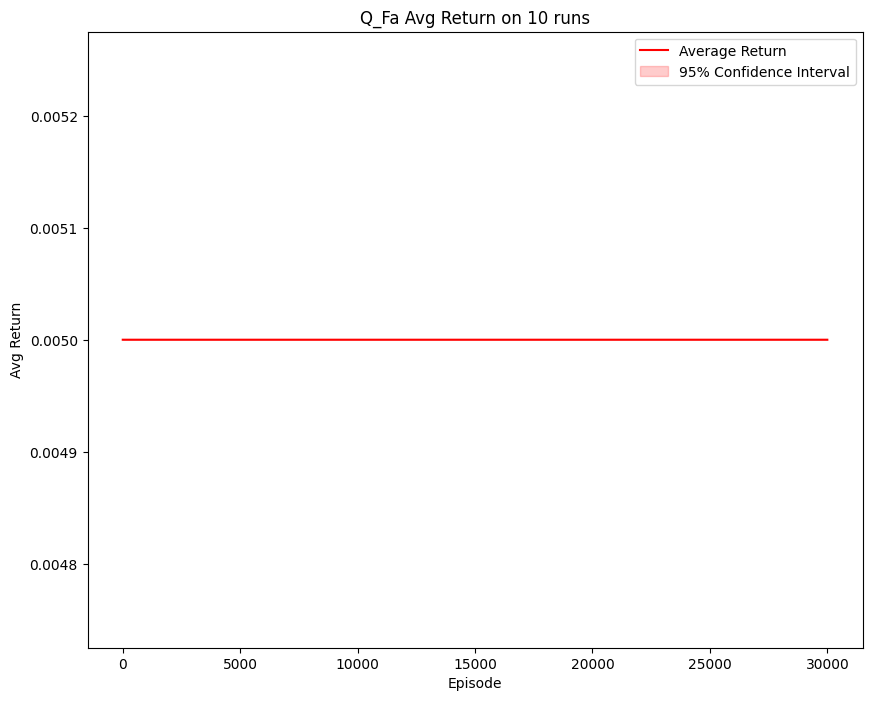

In [7]:
run_experiments(num_runs=num_runs)